# INF554 Team ==Baseline== Node2Vec Feature Extraction and Model Training
### Francisco, Alex and Aksel

## 1.1 Importing Libraries and Loading the Datasets

In [1]:
import random
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
import seaborn as sns
import os
import networkx as nx
import pdb
import pickle
from collections import Counter
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_extraction import text as fe
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
import datetime
import time
import keras
import lightgbm
import spacy
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
import nltk
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin

Using TensorFlow backend.


Note: running all of the following feature extraction cells will take a long time. However, after running for the first time the computationally intensive part of the feature is pickled and so can be easily calculated in subsequent runs. Many of the cells (especially in the feature extraction section) will use this technique.

In [2]:
with open(r"training.txt", "r") as f:
    reader = csv.reader(f)
    training  = list(reader)
# in order of training examples
training = [element[0].split(" ") for element in training]
training = pd.DataFrame(training, columns=['Node1', 'Node2', 'Link'])
print("Training examples shape: {}".format(training.shape))

with open(r"testing.txt", "r") as f:
    reader = csv.reader(f)
    testing  = list(reader)
# in order of testing examples
testing = [element[0].split(" ") for element in testing]
testing = pd.DataFrame(testing, columns=['Node1', 'Node2'])
print("Testing examples shape: {}".format(testing.shape))

Training examples shape: (453797, 3)
Testing examples shape: (113450, 2)


In [3]:
# directory to store extracted features
if not os.path.exists(r'pickles'):
    os.mkdir(r'pickles')

In [4]:
'''
load the corpus one file at a time, remove spaces and convert to lower case
'''
NODE_INFO_DIRECTORY = r"node_information/text/"

corpus_path = r"pickles/simple_corpus.PICKLE" 
ids_path = r"pickles/ids.PICKLE"
if os.path.exists(corpus_path):
    with open(corpus_path, 'rb') as f:
        corpus = pickle.load(f)
    f.close()
    with open(ids_path, 'rb') as f:
        ids = pickle.load(f)
    f.close()
else:
    corpus = []
    ids = []
    for filename in tqdm(os.listdir(NODE_INFO_DIRECTORY), position=0, leave=True):
        with open(NODE_INFO_DIRECTORY + filename, 'r', encoding='UTF-8', errors='ignore') as f:
            doc_string = []
            for line in f:
                [doc_string.append(token.strip()) for token in line.lower().strip().split(" ") if token != ""]
            corpus.append(' '.join(doc_string))
            ids.append(filename[:-4])
    with open(corpus_path, '+wb') as f:
        pickle.dump(corpus, f)
    f.close()
    with open(ids_path, '+wb') as f:
        pickle.dump(ids, f)
    f.close() 

In [5]:
# stemmed corpus is created by Preprocessing.ipynb file
stemmed_corpus_path = r"pickles/stemmed_corpus.PICKLE" 
if os.path.exists(stemmed_corpus_path):
    with open(stemmed_corpus_path, 'rb') as f:
        stemmed_corpus = pickle.load(f)
    f.close()
else:
    print('Stemmed corpus unavailable, please run the Preprocessing.ipynb file')

# in order of alphabetical text information i.e. 0, 1, 10, 100
node_info = pd.DataFrame({'id': ids, 'corpus': corpus, 'stemmed': stemmed_corpus})
node_info_id = node_info.set_index(['id'])
print("Training node info shape: {}".format(node_info.shape))

Training node info shape: (33226, 3)


In [17]:
# make graph/ feature extraction split (saved for reproducable results)
train_graph_split_path = 'pickles/train_graph_split_5.PICKLE'

if os.path.exists(train_graph_split_path):
    with open(train_graph_split_path, 'rb') as f:
        keep_indices = pickle.load(f)
    f.close()
else:
    keep_indices = random.sample(range(len(training)), k=int(len(training) * 0.05))
    with open(train_graph_split_path, '+wb') as f:
        pickle.dump(keep_indices, f)
    f.close()

data_train_val = training.iloc[keep_indices]
data_train = training.loc[~training.index.isin(keep_indices)]

In [18]:
linked_nodes = data_train.loc[data_train['Link']=='1']
linked_nodes = linked_nodes[['Node1', 'Node2']]
linked_nodes.to_csv('linked_nodes.txt', sep=' ', index=False, header=False)
G=nx.read_edgelist('linked_nodes.txt', create_using=nx.Graph(), nodetype = str)
graph=G

In [ ]:
# run INF554_Simple.ipynb before running this file otherwise the files below will not be available
feature_vector_path = r"pickles/perf_val_data_final.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        perf_val_data = pickle.load(f)
    f.close()

feature_vector_path = r"pickles/perf_test_data_final.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        perf_test_data = pickle.load(f)
    f.close()

## 1.2 Load Already Extracted Node2Vec Features

In [20]:
feature_vector_path = r"pickles/perf_val_data_node2vec_final.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        df_train = pickle.load(f)
    f.close()

feature_vector_path = r"pickles/perf_test_data_node2vec_final.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        df_test = pickle.load(f)
    f.close()

In [45]:
# saving the extracted features (disallows overwriting). This function should be run after all features are computed
feature_vector_path = r"pickles/perf_val_data_node2vec_final.PICKLE"
if not os.path.exists(feature_vector_path):
    with open(feature_vector_path, '+wb') as f:
        pickle.dump(df_train, f)
    f.close()
feature_vector_path = r"pickles/perf_test_data_node2vec_final.PICKLE"
if not os.path.exists(feature_vector_path):
    with open(feature_vector_path, '+wb') as f:
        pickle.dump(df_test, f)
    f.close()
    print('Created pickles successfully')

Created pickles successfully


## 2.1 Extracting Node2Vec Features

In [9]:
from node2vec import Node2Vec
from gensim.models import Word2Vec

In [27]:
'''
this function computes the node2vec paths and transition probabilities.
Note that it can take up to 10h to run
'''
node2vec_path = r"pickles/NODE2VEC.PICKLE"
if os.path.exists(node2vec_path):
    print('Node2Vec already calculated')
else:
    x = ''
    while (x not in ['n', 'y']):
        x = input("Node2Vec object not available, recompute? y/n: ")
    if x == "y":
        # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
        node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=1)

Node2Vec already calculated


In [28]:
# it is easier to load the vectors directly without calculating embeddings again
node2vec_model_path = r"pickles/EMBEDDING_MODEL_FILENAME.model"
if os.path.exists(node2vec_model_path):
    model = Word2Vec.load(node2vec_model_path)
else:
    x = ''
    while (x not in ['n', 'y']):
        x = input("Word2Vec model not available, recompute? y/n: ")
    if x == "y":
        # Embed nodes
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        # Save embeddings for later use
        model.wv.save_word2vec_format('pickles/EMBEDDING_FILENAME.embed')
        # Save model for later use
        model.save('pickles/EMBEDDING_MODEL_FILENAME.model')

In [34]:
# embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder
from node2vec.edges import AverageEmbedder
edges_embs = AverageEmbedder(keyed_vectors=model.wv)

In [35]:
# create edge embeddings for each pair of nodes in the training data
embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:43<00:00, 520.94it/s]


In [36]:
# create edge embeddings for each pair of nodes in the testing data
embed_size = len(edges_embs[('0', '1')])
df_test = pd.DataFrame(0, index=np.arange(len(testing)), columns=range(embed_size))
j = []
for i in tqdm(range(len(testing)), position=0, leave=True):
    try:
        df_test.loc[i] = edges_embs[(testing.loc[i]['Node1'], testing.loc[i]['Node2'])]
    except:
        df_test.loc[i] = np.zeros(embed_size)

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [03:39<00:00, 515.85it/s]


## 3.1 Training Model

In [43]:
# compute the train/ test split, dataframe is already normalised
X = df_train
y = list(map(lambda i: int(i), data_train_val['Link']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [44]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.9274774774774774


## 4.1 Kaggle Prediciton

In [92]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X, y)
predictions = model_lgbm.predict(df_test)

In [20]:
final_pred = pd.concat([pd.DataFrame(np.arange(len(df_test))), pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("AverageEmbeder_node2vec_prediction2.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

## Boosting Node2Vec with simple features

In [78]:
from sklearn.preprocessing import StandardScaler

extended_model_train = pd.concat([perf_val_data, df_train], axis =1)
extended_model_test = pd.concat([perf_test_data, df_test], axis =1)
extended_model_test

,Node1,Node2,original_index,tfidf_similarity,languages_similarity,joint_length,file_distance,common_neighbors,jaccard_coefficient,shortest_path,...,54,55,56,57,58,59,60,61,62,63
0,870,10284,0,0.020013,0.472353,2082371091,9414,0,0.000000,4,...,1.036331,4.313026,-1.858926,-3.639827,3.322679,-0.524526,1.997322,-0.511325,0.887013,1.468988
1,620,15300,1,0.302197,0.968905,10964800,14680,12,0.044444,3,...,-1.227498,-4.315487,-4.053194,-2.207743,-1.611002,-2.866664,1.346994,-2.076012,0.284932,1.939911
2,21115,31904,2,0.005682,0.976566,3102536,10789,0,0.000000,4,...,-3.417368,1.324618,0.127317,-1.210228,2.377433,-1.602093,3.773643,-0.114460,-2.186353,-2.762104
3,3021,28396,3,0.001427,0.438494,26860638,25375,0,0.000000,4,...,0.046962,-2.171880,-0.926952,2.565073,-1.080060,0.198457,-0.326231,0.031927,-0.174286,0.030558
4,10780,6135,4,0.035456,0.524943,501323778,4645,8,0.177778,3,...,0.287958,-2.988899,-1.902427,2.746793,-4.253977,0.096233,0.409248,2.156011,-0.349955,3.662336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113445,13419,13751,113445,0.038824,0.992118,1483618868,332,1,0.071429,3,...,1.335053,-3.350636,-0.037663,1.324728,-4.029499,1.235675,-4.355361,-4.515428,1.058179,1.081516
113446,16696,20191,113446,0.000000,0.000000,319676,3495,0,0.000000,5,...,-2.995942,1.214591,-2.882834,-1.282811,3.097563,-1.924950,0.173211,1.489574,1.879185,4.463070
113447,10654,27692,113447,0.002498,0.269025,62737199,17038,0,0.000000,4,...,2.566593,-1.083089,-4.021411,-0.977337,-1.303307,1.283723,1.557155,-2.018146,2.202437,2.021081
113448,5409,1668,113448,0.071846,0.992244,90309525,3741,6,0.027650,3,...,0.646880,-0.188121,7.855142,-6.762398,-2.026963,-3.455606,-7.006221,1.798069,0.594545,-4.042967


In [107]:
d_columns = ['original_index', 'Link', 'Node1', 'Node2']
cols = [i for i in extended_model_train.columns if i not in d_columns]
X = extended_model_train[cols]

y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

scaler = StandardScaler()
normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [95]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.9496238887622521


In [82]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = model_lgbm.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)

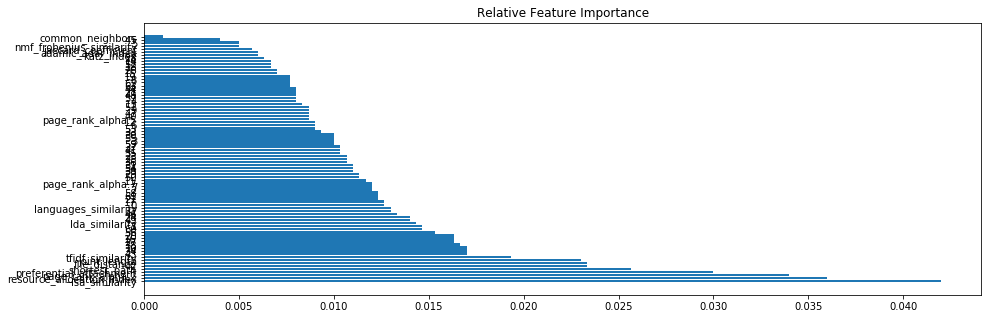

In [83]:
importance = np.array(features.values.reshape(-1))
importance = list(importance/importance.sum(axis=0,keepdims=1))

bars = list(features.index.values)

y_pos = np.arange(len(bars))

fig, ax = plt.subplots(figsize=(15,5))

# Create horizontal bars
plt.barh(y_pos, importance)

# Create names on the y-axis
plt.yticks(y_pos, bars)
# Add title
plt.title("Relative Feature Importance")

# Show graphic
plt.show()

In [87]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X, y)
predictions = model_lgbm.predict(extended_model_test[cols])

In [112]:
final_pred = pd.concat([pd.DataFrame(np.arange(len(df_test))), pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("AverageEmbeder_augmented_ensemble_prediction_add_lsa2.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

In [98]:
d_columns = ['original_index', 'Link', 'Node1', 'Node2']
cols = [i for i in perf_val_data.columns if i not in d_columns]
X = perf_val_data[cols]
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.9407222348398818


In [108]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X, y)
predictions = model_lgbm.predict(extended_model_test[cols])

## Creating simple ensemble

In [109]:
extended_features_predictions = predictions

In [93]:
node2vec_predictions = predictions

In [102]:
simple_predictions = predictions

In [111]:
predictions = np.array([int(i) for i in ((simple_predictions + node2vec_predictions + extended_features_predictions) >= 2)])
predictions



array([1, 1, 0, ..., 0, 1, 1])

In [110]:
len(extended_features_predictions)

113450

In [102]:
print(f1_score(y_test, predictions))

0.9482523831139356


In [118]:
sum(simple_predictions == node2vec_predictions)

99869

In [119]:
sum(extended_features_predictions == node2vec_predictions)

102331

In [120]:
sum(simple_predictions == extended_features_predictions)

109126